## 项目主题
- 基于16/17赛季英格兰超级联赛380场比赛的主客场球队的进球数据，进行相应数据分析
- 基于R编写

## 项目起因
- 这是我本科课程STAT4600(Computational Statistics)的项目之一，很有挑战性但是也伴随着满满收获的一门课。现在整理出来，方便回顾。

## 项目目的
- 输出完整赛季球队排名（包含：积分，进球数，净胜球数）
- 输出具体时间球队排名
- 各球队积分走势图标
- 预测来年输赢

## 英格兰超级联赛背景知识
- 英超共有20支参赛球队，赛季于每年8月至次年5月进行，每赛季英超共有380场比赛，每支球队主场和客场比赛各有19场。所以每支球队总共要踢38场比赛。

- 每场胜方可得3分，平局各得1分，负方得0分，按各队于联赛所得的积分排列。完成所有赛事后总积分最高的队伍可以夺得联赛冠军，而总积分最低的3队球队会降级至英冠联赛。

## 话不多说，正式开始呐。
### 初探数据
- 发现这个是一个380*5的表格，很干净的表格不需要额外的清洗整理。
- 5个列分别表示“日期”、“HT-主场球队”、“AT-客场球队”、“HG-主场球队进球数”、“AG-客场球队进球数”
- 380行表示380场比赛，以第一行为例，2016-08-14 16:00这个时间，主队阿森纳，客队利物浦，主队进球数3，客队进球数4。所以总结起来为主队阿森纳以比分3：4败于客队利物浦。

In [53]:
# 读取 "CSV" 文件
EPl.1617 <- read.csv("../input/EPL_1617.csv", header=T, stringsAsFactors = FALSE)
scores <- EPl.1617
# 表格维度
dim(EPl.1617)
# 前几个行的数据
head(EPl.1617)


[1] 380   5

Date,HT,AT,HG,AG
2016-08-14 16:00,Arsenal,Liverpool,3,4
2016-08-14 13:30,AFC Bournemouth,Manchester United,1,3
2016-08-13 15:00,Burnley,Swansea City,0,1
2016-08-15 20:00,Chelsea,West Ham United,2,1
2016-08-13 15:00,Crystal Palace,West Bromwich Albion,0,1
2016-08-13 15:00,Everton,Tottenham Hotspur,1,1


### 现在380场比赛数据在手，那么什么是我们最想要知道的事情呢。自然而然16/17赛季谁是冠军，谁被降级，这是我们最关心的事情。
- 根据英超赛制，每场胜方可得3分，平局各得1分，负方得0分
- 按照积分高低排名，如果积分一样，按照净胜球数排名，如果净胜球数也一样，按照胜场排序
- 我们想要输出一个汇总表格，显示20支队伍名称，胜场数(W)，平场数(T)，输场数(L)，总积分(Pts)，总进球数(GF)，总丢球数(GA)，净胜球数(GD)

### 创建`season.summary`，当我们输入比分数据，输出各球队汇总的赛季战绩。
#### 代码如下：

In [54]:
# removing the first column "date".
EPl.1617 <- EPl.1617[1:380,2:5]

# "a" is variable of function "season.summary"
season.summary <- function(a){
  wins.team <- c()
  losses.team <- c()
  ties.team <- c()
  # using "for" loop to calculate frequences of wins,losses and ties for every teams.
  for (i in 1:nrow(a)){
    if(a[i,3] > a[i,4]){
      wins.team <- c(wins.team,as.character(a[i,1]))
      losses.team <- c(losses.team,as.character(EPl.1617[i,2]))
    }
    if(a[i,3] < a[i,4]){
      wins.team <- c(wins.team,as.character(EPl.1617[i,2]))
      losses.team <- c(losses.team,as.character(a[i,1]))
    }
    if(a[i,3] == a[i,4]){
      ties.team <- c(ties.team,as.character(a[i,1]),as.character(a[i,2]))
    }
  }
  
  # number of wins <- n.wins
  # number of ties <- n.ties
  # number of losser <- n.losses
  # pts.season is a matrix of points for every team.
  # s.season is a part of final output matrix but without order.
  n.wins <- as.matrix(table(wins.team))
  n.ties <- as.matrix(table(ties.team))
  n.losses <- as.matrix(table(losses.team))
  pts.season <- 3*n.wins+1*n.ties
  s.season <- cbind(n.wins,n.ties,n.losses,pts.season)
  
  library(plyr)
  #goal scores at home
  HG.season <- count(EPl.1617,"HT","HG")
  #goal scores away home
  AG.season <- count(EPl.1617,"AT","AG")
  #total goal scores for each team
  TG.season <- cbind(HG.season,AG.season)
  TG.season <- cbind.data.frame(TG.season[,1],TG.season[,2]+TG.season[,4])
  
  
  #loss scores at home
  HL.season <- count(EPl.1617,"HT","AG")
  #loss scores away home
  AL.season <- count(EPl.1617,"AT","HG")
  #total loss scores for each team
  TL.season <- cbind(HL.season,AL.season)
  TL.season <- cbind.data.frame(TL.season[,1],TL.season[,2]+TL.season[,4])
  
  #goal differnece
  GD.season <- cbind.data.frame(TG.season[,1],TG.season[,2]-TL.season[,2])
  
  #g.season is another part of final answer matrix but without order.
  g.season <- cbind(TG.season,TL.season,GD.season)
  g.season <- g.season[,c(1:2,4,6)]
  
  #combine s.season and g.season to make up final matrix final.season but without order.
  final.season <- cbind(s.season,g.season[,2:4])
  colnames(final.season) <- c("W","T","L","Pts","GF","GA","GD")
  final.season <- as.matrix(final.season)
  
  
  # re-order the table according to decreasing point totals.
  final.season <- final.season[order(final.season[,4],final.season[,7],final.season[,1],decreasing = TRUE),]
  
  
  return(final.season)
  
}

season.summary(a = EPl.1617)

,W,T,L,Pts,GF,GA,GD
Chelsea,30,3,5,93,85,33,52
Tottenham Hotspur,26,8,4,86,86,26,60
Manchester City,23,9,6,78,80,39,41
Liverpool,22,10,6,76,78,42,36
Arsenal,23,6,9,75,77,44,33
Manchester United,18,15,5,69,54,29,25
Everton,17,10,11,61,62,44,18
Southampton,12,10,16,46,41,48,-7
AFC Bournemouth,12,10,16,46,55,67,-12
West Bromwich Albion,12,9,17,45,43,51,-8


### 这里也有更加'Fancy'的写法，用switch来依次填空，结果一样，效率更高，而且队名自动匹配

In [55]:
season.summary <- function(scores, alphabetical=T){
  teams <- sort(unique(c(scores$HT,scores$AT)))     # this works even if a team has only home/away games
  n.teams <- length(teams)
  n.games <- length(scores$HT)
  ##
  # Calculating W-T-L
  #
  WTL <- matrix(0,n.teams,7,dimnames=list(teams,c('W','T','L','GF','GA','GD','Pts')))
  for(j in 1:n.games){
    home <- scores$HT[j]
    away <- scores$AT[j]
    WTL[home,'GF'] <- WTL[home,'GF'] + scores$HG[j]
    WTL[home,'GA'] <- WTL[home,'GA'] + scores$AG[j]
    WTL[away,'GF'] <- WTL[away,'GF'] + scores$AG[j]
    WTL[away,'GA'] <- WTL[away,'GA'] + scores$HG[j]
    if(scores$HG[j] > scores$AG[j]) outcome <- 'H'          # home win in this case 
    if(scores$HG[j] < scores$AG[j]) outcome <- 'A'          # away win
    if(scores$HG[j] == scores$AG[j]) outcome <- 'T'         # Tie
    switch(outcome,
           'A' = {WTL[home,'L'] <- WTL[home,'L']+1 ; WTL[away,'W'] <- WTL[away,'W']+1},
           'T' = {WTL[home,'T'] <- WTL[home,'T']+1 ; WTL[away,'T'] <- WTL[away,'T']+1},
           'H' = {WTL[home,'W'] <- WTL[home,'W']+1 ; WTL[away,'L'] <- WTL[away,'L']+1}
    )
  }
  #
  # Calculating goal difference and points
  #
  WTL[,'GD'] <- WTL[,'GF']-WTL[,'GA']
  WTL[,'Pts'] <- 3*WTL[,'W']+WTL[,'T']
  #
  # In alphabetical order
  #
  if(alphabetical==T) return(WTL)
  #
  # Otherwise, by points total, GD and Wins
  #
  return(WTL[order(WTL[,'Pts'],WTL[,'GD'],WTL[,'W'],decreasing=T),])
}


season.summary(scores = EPl.1617)

,W,T,L,GF,GA,GD,Pts
AFC Bournemouth,12,10,16,55,67,-12,46
Arsenal,23,6,9,77,44,33,75
Burnley,11,7,20,39,55,-16,40
Chelsea,30,3,5,85,33,52,93
Crystal Palace,12,5,21,50,63,-13,41
Everton,17,10,11,62,44,18,61
Hull City,9,7,22,37,80,-43,34
Leicester City,12,8,18,48,63,-15,44
Liverpool,22,10,6,78,42,36,76
Manchester City,23,9,6,80,39,41,78


### 基于上面输出的赛季汇总的表格，我们可以知道：
- 切尔西，托特纳姆热刺，曼城为前三强队伍，这三只球队也是仅有的三支总进球数达到80个的球队。有趣的是冠军切尔西净胜球数却比亚军热刺少了8个，可见热刺平局太多影响了总积分。
- 赫尔城，米德尔斯堡，桑德兰是排在最末尾的三支球队，他们面临降级窘境


### 当有了赛季的summary数据，我们也想要知道具体在某个时间段，这些队伍的表现如何。例如，在赛季开始前的前7周哪支队伍势头最强，或者赛季结束前8周，哪支队伍表现不尽人意。
#### 创建`date.summary`，当我们输入具体的’yyyy-mm-dd’时间段，来自动生成一个具体时间段内汇总信息表格。
#### 代码如下：

In [8]:
date.summary <- function(first.date, second.date, game.results){
  first.date <- as.Date(first.date)
  second.date <- as.Date(second.date)
  game.results.Date <- as.Date(game.results$Date)
  
  if(first.date - second.date >= 0){
    return(paste("The two dates aren???t ordered properly."))
  }
  if(max(game.results.Date) <= first.date | min(game.results.Date) >= second.date){
    return(paste("no games took place between the given dates"))
  } 
  if(ncol(game.results[game.results$Date >= first.date & game.results$Date <= second.date,]) > 0){
    game.results <- game.results[game.results$Date >= first.date & game.results$Date <= second.date,]
    return(season.summary(game.results))
  }
}

- 看看"2016-08-13","2016-09-30"和"2017-04-03","2017-05-21"两个时间段内的各球队表现如何。

- 运行下面代码，由表可知赛季初‘曼城’6胜0负开局，表现非常强势。赛季末‘热刺’和‘切尔西’8胜0负收尾，越踢越热实力强悍。

In [15]:
game.results <- read.csv("../input/EPL_1617.csv", header=T, stringsAsFactors = FALSE)
# To find the first seven weeks of the season. "2016-08-13" to "2016-09-30"
# In the first seven weeks "Manchester City" is the best. "Sunderland" is the worst.
first_seven_weeks <- date.summary("2016-08-13","2016-09-30",game.results)
# To find the last seven weeks of the season. "2017-04-03" to "2017-05-21"
# In last first seven weeks "Tottenham Hotspur" is the best. "West Bromwich Albion" is the worst.
last_seven_weeks <- date.summary("2017-04-03","2017-05-21",game.results)

first_seven_weeks[order(first_seven_weeks[,4], decreasing = TRUE),]
last_seven_weeks[order(last_seven_weeks[,4], decreasing = TRUE),]

,W,T,L,GF,GA,GD,Pts
Manchester City,6,0,0,18,5,13,18
Liverpool,4,1,1,16,9,7,13
Arsenal,4,1,1,15,7,8,13
Manchester United,4,0,2,12,7,5,12
Crystal Palace,3,2,2,11,8,3,11
Everton,4,2,1,11,5,6,14
Chelsea,3,1,2,10,9,1,10
Tottenham Hotspur,4,2,0,10,3,7,14
Watford,2,1,3,10,11,-1,7
Leicester City,2,1,3,8,11,-3,7


,W,T,L,GF,GA,GD,Pts
Tottenham Hotspur,8,0,1,29,5,24,24
Chelsea,8,0,1,25,10,15,24
Manchester City,6,2,1,24,7,17,20
Arsenal,8,0,2,19,8,11,24
Liverpool,5,2,1,14,5,9,17
AFC Bournemouth,3,3,2,13,13,0,12
Leicester City,3,2,4,13,16,-3,11
Crystal Palace,3,1,5,12,16,-4,10
Manchester United,4,4,2,12,6,6,16
Everton,3,2,3,10,11,-1,11


### 到现在为止我们已经知道每支球队的总积分，排名，总进球数等信息，我们已经知道了这些结果，但是我们也想要知道这中间发生了什么，每支球队赛季中具体的表现如何，球队是个什么样的走势。

#### 首先定义一个function`team.progression`，这里progression表示积分累积的意思。当我们输入“比分数据”进这个function，它就会输出每支球队积分的累积过程。

In [16]:
team.progression <- function(game.results){
  k <- rep(0,20)
  count.pts <- rep(0,20)
  teams <- game.results[order(game.results[,1]),]
  teams.name <- sort(unique(c(game.results$HT,game.results$AT)))
  result.matrix <- matrix(0,20,38,byrow = T)
  colnames(result.matrix) <- as.character(c(1:38)) 
  rownames(result.matrix) <- teams.name
  for(i in 1:20){
    for(j in 1:380){
      if(teams.name[i] == teams[j,2]){
        k[i] <- k[i]+1
        if(teams[j,4] > teams[j,5]){
          count.pts[i] <- count.pts[i] + 3
        }
        if(teams[j,4] < teams[j,5]){
          count.pts[i] <- count.pts[i] + 0
        }
        if(teams[j,4] == teams[j,5]){
          count.pts[i] <- count.pts[i] + 1
        }
        result.matrix[i,k] <- count.pts[i]
      }
      if(teams.name[i] == teams[j,3]){
        k[i] <- k[i]+1
        if(teams[j,4] > teams[j,5]){
          count.pts[i] <- count.pts[i] + 0
        }
        if(teams[j,4] < teams[j,5]){
          count.pts[i] <- count.pts[i] + 3
        }
        if(teams[j,4] == teams[j,5]){
          count.pts[i] <- count.pts[i] + 1
        }
        result.matrix[i,k] <- count.pts[i]
      }
    }
  }
  
  return(result.matrix)
}

team.progression(game.results)

,1,2,3,4,5,6,7,8,9,10,⋯,29,30,31,32,33,34,35,36,37,38
AFC Bournemouth,0,0,1,4,4,7,8,11,12,12,⋯,33,34,35,35,35,38,41,42,45,46
Arsenal,0,1,4,7,10,13,16,19,20,23,⋯,54,54,57,60,60,63,66,69,72,75
Burnley,0,3,3,4,4,7,7,7,10,11,⋯,32,32,35,36,36,36,39,40,40,40
Chelsea,3,6,9,10,10,10,13,16,19,22,⋯,69,72,75,75,78,81,84,87,90,93
Crystal Palace,0,0,1,4,7,10,11,11,11,11,⋯,31,31,34,35,38,38,38,38,41,41
Everton,1,4,7,10,13,13,14,15,15,18,⋯,50,50,51,54,57,58,58,58,61,61
Hull City,3,6,6,7,7,7,7,7,7,7,⋯,24,27,30,30,30,33,34,34,34,34
Leicester City,0,1,4,4,7,7,8,8,11,12,⋯,33,36,36,37,37,40,43,43,43,44
Liverpool,3,3,4,7,10,13,16,17,20,23,⋯,56,59,60,63,66,66,69,70,73,76
Manchester City,3,6,9,12,15,18,18,19,20,23,⋯,58,58,61,64,65,66,69,72,75,78


### 数据不够直观，别担心，我们可以把它画出来
- 首先看看“切尔西”表现如何

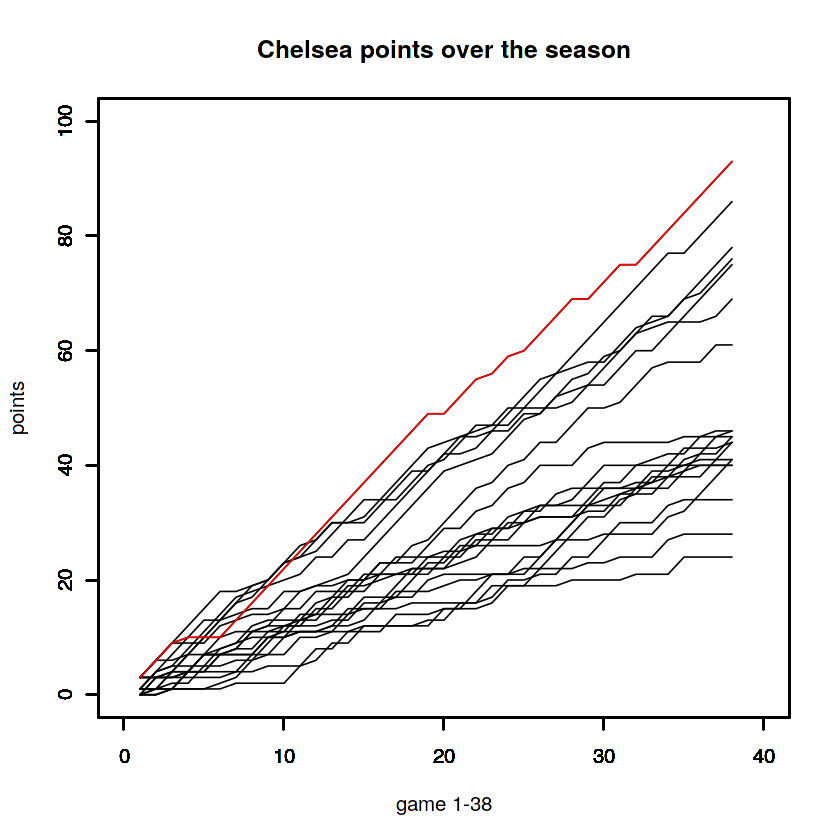

In [18]:
# Chelsea's domination over the season.
for(i in 1:20){
  plot(team.progression(game.results)[i,],xlim = c(0,40),ylim = c(0,100),xlab="",ylab = "",type = "l")
  par( new = TRUE)
}
par(new = T)
plot(team.progression(game.results)[4,],xlim = c(0,40),ylim = c(0,100),xlab="game 1-38",ylab = "points",type = "l",col = "red")
title(main = "Chelsea points over the season")

#### 很明显可以看出赛季冠军切尔西，在图中一枝独秀，虽然赛季初表现一般，不过大概十场以后开始发力，并一直保持优势到38场比赛结束。
- 再看看最后一名“桑德兰"同学的表现如何。

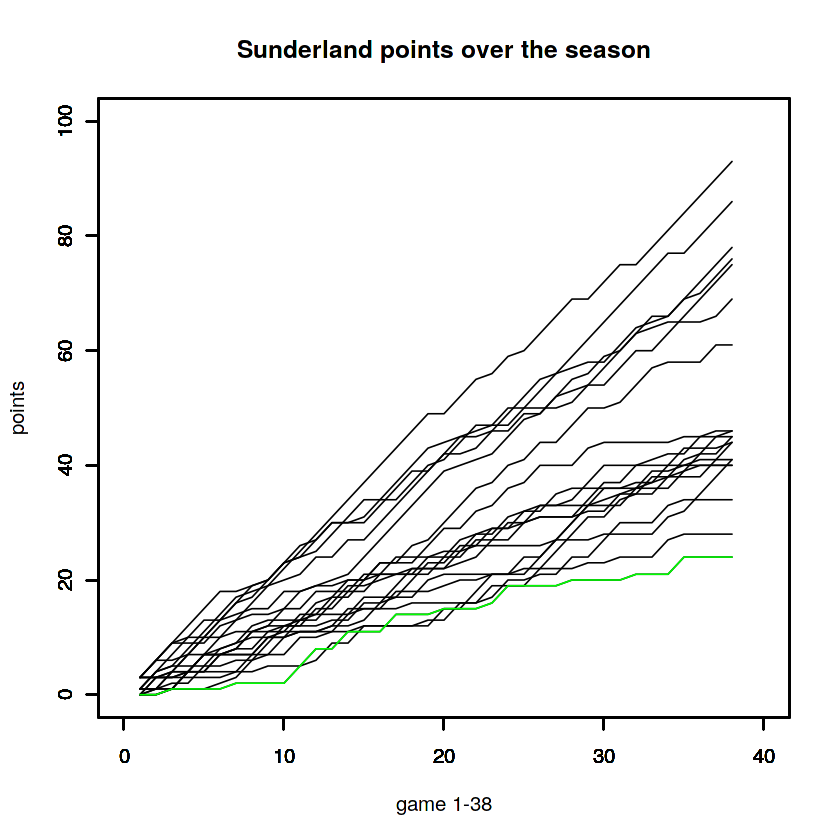

In [20]:
# Sunderland's performance over the season.
for(i in 1:20){
  plot(team.progression(game.results)[i,],xlim = c(0,40),ylim = c(0,100),xlab="",ylab = "",type = "l")
  par( new = TRUE)
}
par(new = T)
plot(team.progression(game.results)[15,],xlim = c(0,40),ylim = c(0,100),xlab="game 1-38",ylab = "points",type = "l",col = "green")
title(main = "Sunderland points over the season")

### 如果想基于现有的数据，我们知道了这些排名，通过排名可以反映实例的强弱，但是我们也想量化每个球队的进攻能力，防守能力，主场优势等等。首先我们明确，主场和客场进球数是属于泊松分布的。基于Lee的论文，我们得到这么一个模型。这里每个参数都有相对应的解释。
- 模型：--------
- `mu`：整体联赛得分参数
- `delta`：主场球队得分参数，这个参数反应主场优势
- `alpha`：球队的进攻能力参数，越大的正数，表示火力越强
- `beta`：球队的防守能力参数，越小的负数，表示防守越好

#### 第一步，找到各个球队对应的参数，这里我们用MLE来估计参数。因为因变量进球数是离散型的变量，所以我们不用lm，改用glm做线性回归，得到估计参数。

In [25]:
soccer.estimates <- function(scores){
  #
  # Building the X matrix for GLM fit
  #
  home.teams <- as.character(scores[,'HT'])
  away.teams <- as.character(scores[,'AT'])
  teams <- sort(unique(c(home.teams,away.teams)))   
  n.teams <- length(teams)
  n.games <- length(home.teams)
  Home <- matrix(0,n.games,n.teams-1)
  Away <- matrix(0,n.games,n.teams-1)
  for(j in 1:n.games){
    home <- which(home.teams[j]==teams)
    away <- which(away.teams[j]==teams)
    if(home <= (n.teams-1)){
      Home[j,] <- rep(0,n.teams-1)
      Home[j,home] <- 1
    }
    else{
      Home[j,] <- rep(-1,n.teams-1)
    }
    if(away <= (n.teams-1)){
      Away[j,] <- rep(0,n.teams-1)
      Away[j,away] <- 1
    }
    else{
      Away[j,] <- rep(-1,n.teams-1)
    }
  }
  home.matrix <- cbind(rep(1,n.games),rep(1,n.games),Home,Away)
  away.matrix <- cbind(rep(1,n.games),rep(0,n.games),Away,Home)
  design.matrix<-rbind(home.matrix,away.matrix)
  #
  # The response vector
  #
  home.scores <- scores[,'HG']
  away.scores <- scores[,'AG']
  response.vector <- c(home.scores,away.scores)
  #
  # Fitting the Poisson model
  #
  model.fit <- glm(response.vector~0+design.matrix,family=poisson(link='log'))
  mu <- model.fit$coef[1]
  names(mu) <- NULL
  delta <- model.fit$coef[2]
  names(delta) <- NULL
  alpha <- c(model.fit$coef[3:21],-sum(model.fit$coef[3:21]))
  names(alpha) <- teams
  beta <- c(model.fit$coef[22:40],-sum(model.fit$coef[22:40]))
  names(beta) <- teams
  return(list(mu=mu,delta=delta,alpha=alpha,beta=beta))
}

specific.par <- soccer.estimates(game.results)
specific.par

$mu
[1] 0.08914064

$delta
[1] 0.2838454

$alpha
     AFC Bournemouth              Arsenal              Burnley 
         0.103478277          0.417913455         -0.253228722 
             Chelsea       Crystal Palace              Everton 
         0.505970488          0.003807829          0.200580419 
           Hull City       Leicester City            Liverpool 
        -0.281154307         -0.037140169          0.428839206 
     Manchester City    Manchester United        Middlesbrough 
         0.451211038          0.047411882         -0.623517052 
         Southampton           Stoke City           Sunderland 
        -0.209975154         -0.202127634         -0.536320619 
        Swansea City    Tottenham Hotspur              Watford 
        -0.094860590          0.510671989         -0.214989646 
West Bromwich Albion      West Ham United 
        -0.159314156         -0.057256533 

$beta
     AFC Bournemouth              Arsenal              Burnley 
         0.275693812         -0.124087461          0.061818612 
             Chelsea       Crystal Palace              Everton 
        -0.404600269          0.208884238         -0.139133033 
           Hull City       Leicester City            Liverpool 
         0.435460169          0.206881125         -0.169754565 
     Manchester City    Manchester United        Middlesbrough 
        -0.242084408         -0.564724771          0.013020155 
         Southampton           Stoke City           Sunderland 
        -0.072622876          0.081842776          0.279213857 
        Swansea City    Tottenham Hotspur              Watford 
         0.309560070         -0.642608951          0.275483896 
West Bromwich Albion      West Ham United 
        -0.009918848          0.221676472

### 基于上面的参数，我们可以预测新一轮的进球数。

In [27]:
# define a function new season.

new.season <- function(calendar,mu,delta,alpha,beta){
  
  home.teams <- as.character(calendar[,'HT'])
  away.teams <- as.character(calendar[,'AT'])
  teams <- sort(unique(c(home.teams,away.teams)))   
  par.mu <- rep(mu,nrow(calendar))
  par.delta <- rep(delta, nrow(calendar))
  par.alpha.i <- c(0,nrow(calendar))
  par.beta.i <- c(0,nrow(calendar))
  par.alpha.j <- c(0,nrow(calendar))
  par.beta.j <- c(0,nrow(calendar))
  
  for(i in 1:length(teams)){
    a <- which(home.teams == teams[i])
    par.alpha.i[a] <- alpha[teams[i],]
    par.beta.i[a] <- beta[teams[i],]
  }
  
  for(i in 1:length(teams)){
    a <- which(away.teams == teams[i])
    par.alpha.j[a] <- alpha[teams[i],]
    par.beta.j[a] <- beta[teams[i],]
  }
  # table1 gives a data.frame containing calendar of games and the parameters mu, Delta, alpha and beta of the model.
  table1 <- cbind(calendar,par.mu,par.delta,par.alpha.i,par.beta.i,par.alpha.j,par.beta.j)
  
  # table2 gives a data frame containing the calendar and scores to all the games 
  # in the same format as the soccer object we have used before.
  HG <- apply(table1[,4:9],1,function(x) rpois(n=1,lambda = exp(x[1]+x[2]+x[3]+x[6])))
  AG <- apply(table1[,4:9],1,function(x) rpois(n=1,lambda = exp(x[1]+x[5]+x[4])))
  table2 <- cbind(calendar, HG, AG)
  
  return(table2)
}

soccer <- read.csv("../input/EPL_1617.csv", header=T, stringsAsFactors = FALSE)

estimates <- soccer.estimates(soccer)
calendar <- game.results[,1:3]
mu <- as.numeric(estimates$mu)
delta <- as.numeric(estimates$delta)
alpha <- as.data.frame(estimates$alpha)
beta <- as.data.frame(estimates$beta)

#producing a new season.
NewSeason <- new.season(calendar,mu,delta,alpha,beta)
head(NewSeason)

Date,HT,AT,HG,AG
2016-08-14 16:00,Arsenal,Liverpool,5,3
2016-08-14 13:30,AFC Bournemouth,Manchester United,1,2
2016-08-13 15:00,Burnley,Swansea City,0,1
2016-08-15 20:00,Chelsea,West Ham United,3,0
2016-08-13 15:00,Crystal Palace,West Bromwich Albion,1,0
2016-08-13 15:00,Everton,Tottenham Hotspur,0,4


#### 上面我们得到了新一个赛季的比赛情况，基于新一个赛季的比分，我们可以得到一组相应的新的估计参数

### 我们可以重复这个步骤`N`次，得到N组不同的估计参数，然后我们取90%的置信区间，得到下面的表格

In [28]:
# the game.results of a season of interest
# the number N of replicates of the full season that should be used for bootstrapping
# the confidence level C that is desired

# define a par.bootstrap function to find confidence interval for all parameters.
par.bootstrap <- function(calendar,mu,delta,alpha,beta, N, C){
  teams <- sort(unique(c(as.character(EPl.1617[,'HT']),as.character(EPl.1617[,'AT'])))) 
  # for every bootstrap, get 42 pars and put it in a single cols. N times bootstrap, N cols pars.
  bootstrap.sample <- matrix(NA,nrow = 42,ncol = N)
  for(i in 1:N){
    bootstrap.sample[,i] <- unlist(soccer.estimates(new.season(calendar,mu,delta,alpha,beta)), use.names = FALSE)
  }
  CI <- t(apply(bootstrap.sample,1,function(x) quantile(x,probs=c(C/2,1-C/2))))
  name.alpha <- paste(teams, "alpha",sep = "__")
  name.beta <- paste(teams, "beta",sep = "__")
  row.names(CI) <- c('mu','Delta',name.alpha,name.beta)
  return(CI)
}
# if N is large, may take a while to get answer.
CI.bootstrap <- par.bootstrap(calendar,mu,delta,alpha,beta,N=100,C=0.1)
CI.bootstrap

,5%,95%
mu,-0.001388508,0.140999819
Delta,0.185564810,0.373485127
AFC Bournemouth__alpha,-0.193802993,0.309880359
Arsenal__alpha,0.212893568,0.616712253
Burnley__alpha,-0.512035405,-0.005075269
Chelsea__alpha,0.303961570,0.657676474
Crystal Palace__alpha,-0.242234393,0.200468069
Everton__alpha,-0.016524598,0.378445372
Hull City__alpha,-0.576345745,-0.014966067
Leicester City__alpha,-0.337115267,0.212772281


#### 这样我们就量化了每个球队的进攻和防守强弱，主场优势等数值。

#### 然后我们看看平均下来，各个球队的排名如何

In [35]:
# First defining a function that returns the ranks of each team at the end
# of a season, given the scores to all the games (using the summary function
# of Assignment 2)
#
season.ranks <- function(scores){
  summary.table <- season.summary(scores,F)			# teams are then ranked
  ranks <- order(rownames(summary.table))
  return(ranks)
}
#
# A function for calculating the average rank from a vector of rank counts
#
avgrank <- function(obs.ranks){
  sum((1:length(obs.ranks))*obs.ranks)/sum(obs.ranks)
}

# Simulating seasons and producing rank summaries
#
simulate.seasons <- function(calendar,mu,Delta,alpha,beta,N.seasons){
  teams <- row.names(alpha)
  n.teams <- length(teams)
  team.ranks <- matrix(0,n.teams,n.teams,dimnames=list(teams,1:n.teams))		# the table to be returned
  for(j in 1:N.seasons){
    new.ranks <- season.ranks(new.season(calendar,mu,Delta,alpha,beta))		# the ranks for season j
    current.ranks <- matrix(0,n.teams,n.teams)								# the matrix of rank indicators
    for(k in 1:n.teams){
      current.ranks[k,new.ranks[k]] <- 1
    }
    team.ranks <- team.ranks+current.ranks			# adds one instance of appropriate rank for each team
  }
  average.rank <- apply(team.ranks,1,avgrank)						# the average rank for each team
  return(cbind(team.ranks, AvgRank=average.rank))
}
#
rank.table <- simulate.seasons(calendar, mu, delta, alpha, beta, 100)
rank.table

,1,2,3,4,5,6,7,8,9,10,⋯,12,13,14,15,16,17,18,19,20,AvgRank
AFC Bournemouth,0,0,0,0,0,0,5,11,18,7,⋯,7,9,6,9,6,6,1,3,2,11.98
Arsenal,4,7,15,21,16,19,15,3,0,0,⋯,0,0,0,0,0,0,0,0,0,4.70
Burnley,0,0,0,0,0,1,1,6,4,8,⋯,16,13,15,5,6,8,2,4,0,12.88
Chelsea,20,42,21,6,6,5,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,2.51
Crystal Palace,0,0,0,0,0,0,4,6,16,11,⋯,10,10,12,5,5,5,1,0,0,11.71
Everton,0,0,3,9,17,23,35,8,3,2,⋯,0,0,0,0,0,0,0,0,0,6.24
Hull City,0,0,0,0,0,0,0,0,0,0,⋯,0,3,3,3,7,7,15,29,32,18.29
Leicester City,0,0,0,0,0,0,5,10,11,5,⋯,9,8,11,8,9,6,4,2,0,12.38
Liverpool,5,12,19,25,19,11,8,0,1,0,⋯,0,0,0,0,0,0,0,0,0,4.12
Manchester City,2,12,26,21,17,17,5,0,0,0,⋯,0,0,0,0,0,0,0,0,0,4.10


#### 横轴为各支球队获得排名1-20的次数：我们模拟了100个赛季，发现切尔西、热刺夺冠次数最多，利物浦、曼城、曼联偶尔夺冠

### 看看每支球队降级的概率：

In [44]:
#
# To obtain the approximate probabilities of relegation for all the teams
#
rlgation <- rowSums(rank.table[,18:20])/100
rlgation[order(rlgation,decreasing = TRUE)]

Hull City           Sunderland        Middlesbrough 
                0.76                 0.73                 0.45 
             Watford         Swansea City      West Ham United 
                0.41                 0.22                 0.14 
          Stoke City      AFC Bournemouth              Burnley 
                0.07                 0.06                 0.06 
      Leicester City West Bromwich Albion       Crystal Palace 
                0.06                 0.03                 0.01 
             Arsenal              Chelsea              Everton 
                0.00                 0.00                 0.00 
           Liverpool      Manchester City    Manchester United 
                0.00                 0.00                 0.00 
         Southampton    Tottenham Hotspur 
                0.00                 0.00

### 各球队夺冠的概率是多少

In [46]:
#
# From reading the first column!
#
cmp <- rank.table[,1]/100
cmp[order(cmp, decreasing = TRUE)]

Tottenham Hotspur              Chelsea            Liverpool 
                0.68                 0.20                 0.05 
             Arsenal      Manchester City    Manchester United 
                0.04                 0.02                 0.01 
     AFC Bournemouth              Burnley       Crystal Palace 
                0.00                 0.00                 0.00 
             Everton            Hull City       Leicester City 
                0.00                 0.00                 0.00 
       Middlesbrough          Southampton           Stoke City 
                0.00                 0.00                 0.00 
          Sunderland         Swansea City              Watford 
                0.00                 0.00                 0.00 
West Bromwich Albion      West Ham United 
                0.00                 0.00

### 各球队进去前七的概率
#### 阿森纳、切尔西、曼城、热刺、曼联和利物浦这几次球队几乎100%会进入前7。正好他们也是几支英超传统强队

In [47]:
#
# For Top 7 finishes
#
top_seven <- rowSums(rank.table[,1:7])/100
top_seven[order(top_seven, decreasing = TRUE)]

Chelsea      Manchester City    Tottenham Hotspur 
                1.00                 1.00                 1.00 
           Liverpool              Arsenal    Manchester United 
                0.99                 0.97                 0.96 
             Everton      AFC Bournemouth       Leicester City 
                0.87                 0.05                 0.05 
      Crystal Palace          Southampton              Burnley 
                0.04                 0.03                 0.02 
          Stoke City West Bromwich Albion            Hull City 
                0.01                 0.01                 0.00 
       Middlesbrough           Sunderland         Swansea City 
                0.00                 0.00                 0.00 
             Watford      West Ham United 
                0.00                 0.00